<a href="https://colab.research.google.com/github/Rotem2411/alephBERTgimmelDalet/blob/main/Sentiment_Ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from string import punctuation
from transformers import AutoTokenizer, AutoModel, pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
def read_csv_file(file_path):
    data = []
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            data.append(row)
    return data

In [3]:
    file_path = 'sentiments.csv'
    df = pd.read_csv(file_path)
    print(df.head(10))

    # Total number of samples
    num_samples = len(df)
    print("Total number of samples:", num_samples)

    # Sentiment distribution
    Sentiment_distribution = {}
    for index, row in df.iterrows():
        Sentiment_label = row['tag']
        if Sentiment_label not in Sentiment_distribution:
            Sentiment_distribution[Sentiment_label] = 1
        else:
            Sentiment_distribution[Sentiment_label] += 1
    print("Sentiment Distribution:")
    for Sentiment_label, count in Sentiment_distribution.items():
        print(f"{Sentiment_label}: {count} tags")

   id                                               text tag category class  \
0   1                    האריות של הצל חזק פה בתגובות...   ש  ECONOMY    b1   
1   2  זמרת תעשייה רק מפרסומות מפורסמת\n  אבל אין קהל...   ש  ECONOMY    b1   
2   4  את לא יורקת לבאר שממנה שתית. יפה יפה, אבל חסרת...   ש  ECONOMY    b1   
3   5  שמעון\n  משתתף בפרסומת למילקי במקום לעורר מודע...   ש  ECONOMY    b1   
4   6  הצחקתם אותי\n  מה כל כך אמייזינג בחברה עם אפס ...   ש  ECONOMY    b1   
5   7  איסו חברת הייטק מצליחה צריכה פרסומות שיבואו לע...   ש  ECONOMY    b1   
6   8           לא מכיר אותה ולא שמעתי אפילו שיר אחד שלה   ש  ECONOMY    b1   
7   9  וואללה לא יודע מה מתלהבים מנגה ארז. זה בכלל לא...   ש  ECONOMY    b1   
8  10  אהובה שגיא\n  נגה גדולה.זמרת מעולה.פרסומת מדלי...   ח  ECONOMY    b1   
9  11  הפרסומת של אמדוקס נראית מאוד קודרת ואפורה, כמו...   ש  ECONOMY    b1   

   total_tags  selected_tag  polarity  
0           2             2       1.0  
1           2             2       1.0  
2         

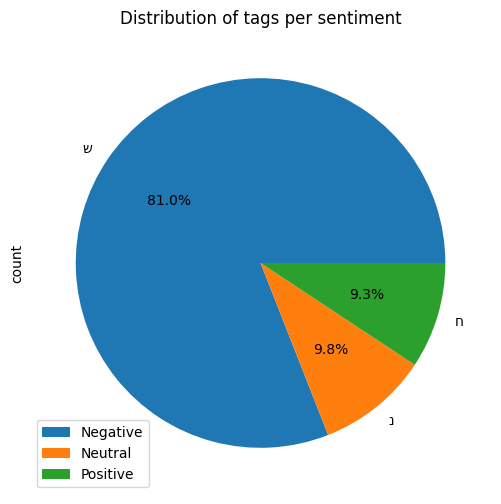

In [4]:
df['tag'].value_counts().plot.pie(figsize=(6,6),title="Distribution of tags per sentiment", autopct='%1.1f%%')
labels=["Negative", "Neutral", "Positive"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')

In [5]:
    nltk.download('punkt')

    # Tokenize each text into words, excluding punctuation, and flatten the list of tokenized words
    all_words = [word for text in df['text'] for word in nltk.word_tokenize(text) if word not in punctuation]

    # Tokenize each text into sentences
    all_sentences = [sentence for text in df['text'] for sentence in nltk.sent_tokenize(text)]

    # Count the occurrences of each word
    word_counts = Counter(all_words)

    print("There are", len(set(all_words)) , " different words in the text.")
    print("The top 10 most common words are: ", word_counts.most_common(10))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


There are 106891  different words in the text.
The top 10 most common words are:  [('לא', 29679), ('את', 23642), ('זה', 14142), ('של', 14048), ('על', 13068), ('כל', 8932), ('מה', 8132), ("''", 7981), ('עם', 7329), ('גם', 6241)]


We can see there are 75,151 tags and there's not a single null value.

All the sentences were annotated by crowd members(2-5 annotators) to sentiment: positive, negative or neutral.

Since there are too many examples for our computation capacity, we'll split the dataset and reduce it.

First, we'll reduce the data set to 10% and then we'll keep 50% for the training set and 25% both for the validation and the test set.

In [6]:
features = df['text']
labels = df['tag']

X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size = 0.90, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size = 0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size = 0.5, random_state=42)

print("Data distribution:\n- Train: {} \n- Validation: {} \n- Test: {}".format(len(y_train),len(y_val),len(y_test)))

Data distribution:
- Train: 3757 
- Validation: 1879 
- Test: 1879


In [7]:
def vectorize(data, tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names_out()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

In [8]:
def clean(text):
    wn = nltk.WordNetLemmatizer()
    stopword = nltk.corpus.stopwords.words('hebrew')
    tokens = nltk.word_tokenize(text)
    lower = [word.lower() for word in tokens]
    no_stopwords = [word for word in lower if word not in stopword]
    no_alpha = [word for word in no_stopwords if word.isalpha()]
    lemm_text = [wn.lemmatize(word) for word in no_alpha]
    clean_text = lemm_text
    return clean_text

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')
tfidf_vect = TfidfVectorizer(analyzer=clean)
tfidf_vect_fit=tfidf_vect.fit(X_train)
X_train = vectorize(X_train, tfidf_vect_fit)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


We explore first results of a Random Forest Classifier without any hyperparameter tuning using 10-cross-fold validation

In [10]:
rf = RandomForestClassifier()
scores = cross_val_score(rf,X_train,y_train.values.ravel(),cv=10)

In [11]:
print(scores)
scores.mean()

[0.84042553 0.84042553 0.84574468 0.82712766 0.81914894 0.82978723
 0.84308511 0.84266667 0.85066667 0.83733333]


0.8376411347517732

Now we'll do some hyperparameter tuning using GridSearchCV.

In [12]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [13]:
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5,50,100],
    'max_depth': [2,10,20,None]
}

cv = GridSearchCV(rf,parameters)
cv.fit(X_train,y_train.values.ravel())
print_results(cv)

BEST PARAMS: {'max_depth': None, 'n_estimators': 100}

0.82 (+/-0.001) for {'max_depth': 2, 'n_estimators': 5}
0.82 (+/-0.001) for {'max_depth': 2, 'n_estimators': 50}
0.82 (+/-0.001) for {'max_depth': 2, 'n_estimators': 100}
0.82 (+/-0.001) for {'max_depth': 10, 'n_estimators': 5}
0.82 (+/-0.001) for {'max_depth': 10, 'n_estimators': 50}
0.82 (+/-0.001) for {'max_depth': 10, 'n_estimators': 100}
0.821 (+/-0.001) for {'max_depth': 20, 'n_estimators': 5}
0.82 (+/-0.001) for {'max_depth': 20, 'n_estimators': 50}
0.82 (+/-0.001) for {'max_depth': 20, 'n_estimators': 100}
0.825 (+/-0.015) for {'max_depth': None, 'n_estimators': 5}
0.837 (+/-0.011) for {'max_depth': None, 'n_estimators': 50}
0.837 (+/-0.015) for {'max_depth': None, 'n_estimators': 100}


For the evaluation of the validation set, first we need to transform it using the same features as the training set. Then, we can evaluate our best models from CV on it.

In [14]:
X_val=vectorize(X_val,tfidf_vect_fit)

In [15]:
rf1 = RandomForestClassifier(n_estimators=100,max_depth=20)
rf1.fit(X_train, y_train.values.ravel())
rf2 = RandomForestClassifier(n_estimators=100,max_depth=None)
rf2.fit(X_train, y_train.values.ravel())
rf3 = RandomForestClassifier(n_estimators=5,max_depth=None)
rf3.fit(X_train, y_train.values.ravel())

RandomForestClassifier(n_estimators=5)

In [16]:
for mdl in [rf1,rf2,rf3]:
    y_pred = mdl.predict(X_val)
    accuracy = round(accuracy_score(y_val, y_pred), 3)
    precision = round(precision_score(y_val, y_pred, average='micro'), 3)
    recall = round(recall_score(y_val,y_pred, average='micro'), 3)
    print('MAX DEPTH: {} / # OF EST: {} -- A: {} / P: {} / R: {}'.format(mdl.max_depth,
                                                                         mdl.n_estimators,
                                                                         accuracy,
                                                                         precision,
                                                                         recall))

MAX DEPTH: 20 / # OF EST: 100 -- A: 0.809 / P: 0.809 / R: 0.809
MAX DEPTH: None / # OF EST: 100 -- A: 0.821 / P: 0.821 / R: 0.821
MAX DEPTH: None / # OF EST: 5 -- A: 0.803 / P: 0.803 / R: 0.803


Finally, we can see the the best model is the second one:

MAX DEPTH: None / # OF EST: 100

So now we will evaluate the best model on the test set.

In [17]:
X_test=vectorize(X_test,tfidf_vect_fit)

y_pred = rf2.predict(X_test)
accuracy = round(accuracy_score(y_test,y_pred), 3)
precision = round(precision_score(y_test,y_pred, average='micro'), 3)
recall = round(recall_score(y_test,y_pred, average='micro'), 3)
print('MAX DEPTH: {} / # OF EST: {} -- A: {} / P: {} / R: {}'.format(rf2.max_depth,
                                                                     rf2.n_estimators,
                                                                     accuracy,
                                                                     precision,
                                                                     recall))

MAX DEPTH: None / # OF EST: 100 -- A: 0.819 / P: 0.819 / R: 0.819


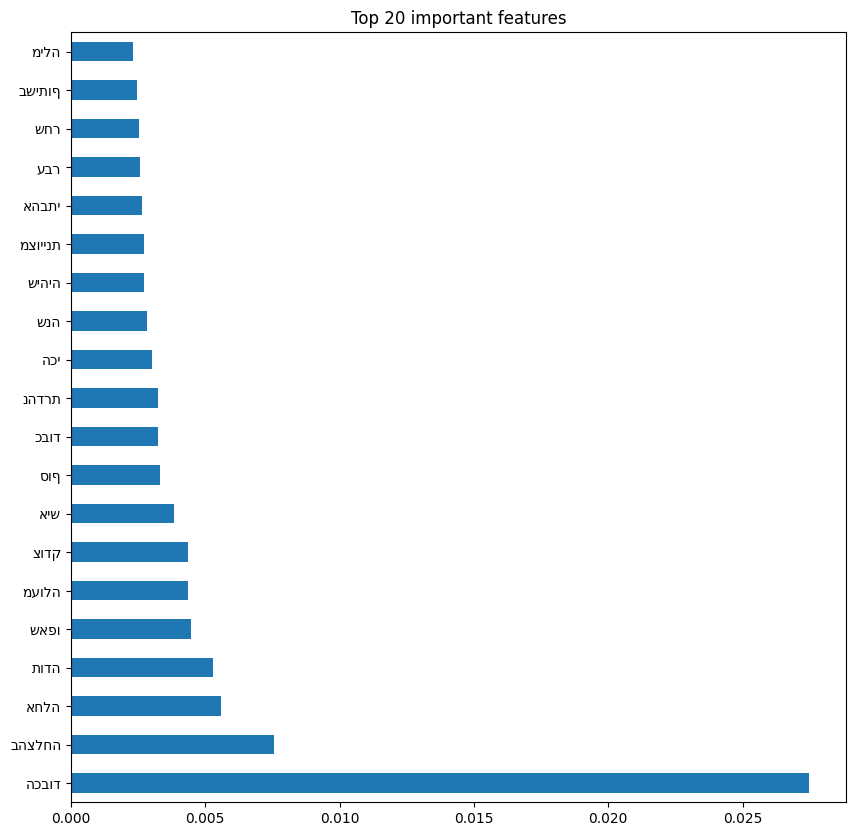

In [18]:
feat_importances = pd.Series(rf2.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh',figsize=(10,10))
plt.title("Top 20 important features")
plt.show()

In [19]:
feat_importances.nlargest(20)

הכבוד      0.027475
בהצלחה     0.007573
אחלה       0.005581
תודה       0.005286
שאפו       0.004458
מעולה      0.004366
צודק       0.004352
איש        0.003828
סוף        0.003329
כבוד       0.003248
נהדרת      0.003233
הכי        0.003031
שנה        0.002814
שיהיה      0.002730
מצויינת    0.002713
אהבתי      0.002662
עבר        0.002584
שחר        0.002537
בשיתוף     0.002447
מילה       0.002307
dtype: float64

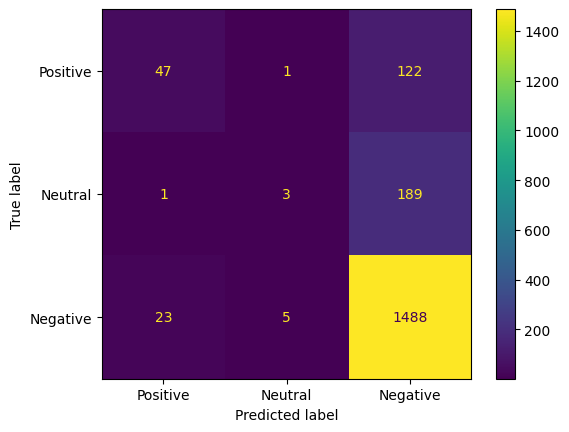

In [20]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Positive", "Neutral", "Negative"])
cm_display.plot()
plt.show()

LDA - Latent Dirichlet allocation

In [21]:
documents = df['text'].tolist()
tfidf_matrix = tfidf_vect.fit_transform(documents)
num_topics = 3
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=100)
lda_matrix = lda_model.fit_transform(tfidf_matrix)

# Print the top words for each topic
feature_names = tfidf_vect.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

Topic 1: צריך, שלא, הזה, ולא, אחד, עוד, המדינה, בכל, כמה, אפשר
Topic 2: שלא, ביבי, ישראל, טוב, ב, לך, הכבוד, פלג, עוד, שאתה
Topic 3: כבר, לך, ביבי, ולא, עוד, צריך, כסף, טוב, ישראל, הרבה
